In [1]:
import osqp
import numpy as np
import scipy.sparse as sp

class CBFController:
    def __init__(self, x_min, x_max, gamma):
        self.x_min = x_min
        self.x_max = x_max
        self.gamma = gamma
        self.qp = osqp.OSQP()
        self.setup_qp()

    def setup_qp(self):
        # Quadratic cost matrix (1/2 * u^2)
        P = sp.csc_matrix([[1.0]])  # Minimize (u - u_des)^2
        q = np.array([0.0])  # Linear term (will be updated each time)

        # Constraint matrices (A * u <= b)
        A = np.array([[1.0], [-1.0]])  # Bounds on u
        A = sp.csc_matrix(A)
        l = np.array([-np.inf, -np.inf])  # Will be updated
        u = np.array([np.inf, np.inf])  # Will be updated

        # Setup OSQP problem
        self.qp.setup(P, q, A, l, u, verbose=False)

    def compute_control(self, x, u_des):
        # Update constraints
        l = np.array([-self.gamma * (x - self.x_min), -np.inf])
        u = np.array([self.gamma * (self.x_max - x), np.inf])  # u <= gamma * (x_max - x)

        # Update OSQP solver
        self.qp.update(l=l, u=u, q=np.array([-u_des]))  # Minimize (u - u_des)^2

        # Solve
        res = self.qp.solve()
        return res.x[0] if res.info.status == 'solved' else u_des  # Return safe control


In [2]:
import matplotlib.pyplot as plt
import numpy as np

def simulate_and_plot(controller, x0, u_des_func, T, dt):
    """
    Simulates the system with a given CBF controller and plots the results.

    Parameters:
    - controller: An instance of the CBFController class.
    - x0: Initial state.
    - u_des_func: Function u_des_func(t) that provides desired control input.
    - T: Total simulation time.
    - dt: Time step for integration.
    """
    t_vals = np.arange(0, T, dt)  # Time vector
    x_vals = np.zeros_like(t_vals)  # State trajectory
    u_vals = np.zeros_like(t_vals)  # Applied control inputs
    u_des_vals = np.zeros_like(t_vals)  # Desired control inputs

    x = x0  # Initialize state
    for i, t in enumerate(t_vals):
        u_des = u_des_func(t)  # Desired input
        u_safe = controller.compute_control(x, u_des)  # Get safe control

        # Store values
        x_vals[i] = x
        u_vals[i] = u_safe
        u_des_vals[i] = u_des

        # Integrate system dynamics (Euler method)
        x = x + dt * u_safe

    # Plot results
    fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    # State plot
    axs[0].plot(t_vals, x_vals, label="State x", color="blue")
    axs[0].axhline(controller.x_max, color="red", linestyle="--", label="x_max")
    axs[0].axhline(controller.x_min, color="green", linestyle="--", label="x_min")
    axs[0].set_ylabel("State x")
    axs[0].set_title("System State Evolution")
    axs[0].legend()
    axs[0].grid()

    # Control input plot
    axs[1].plot(t_vals, u_des_vals, label="Desired u", color="gray", linestyle="dashed")
    axs[1].plot(t_vals, u_vals, label="Applied u", color="blue")
    axs[1].set_xlabel("Time [s]")
    axs[1].set_ylabel("Control input u")
    axs[1].set_title("Control Input vs. Desired Input")
    axs[1].legend()
    axs[1].grid()

    plt.tight_layout()
    plt.show()


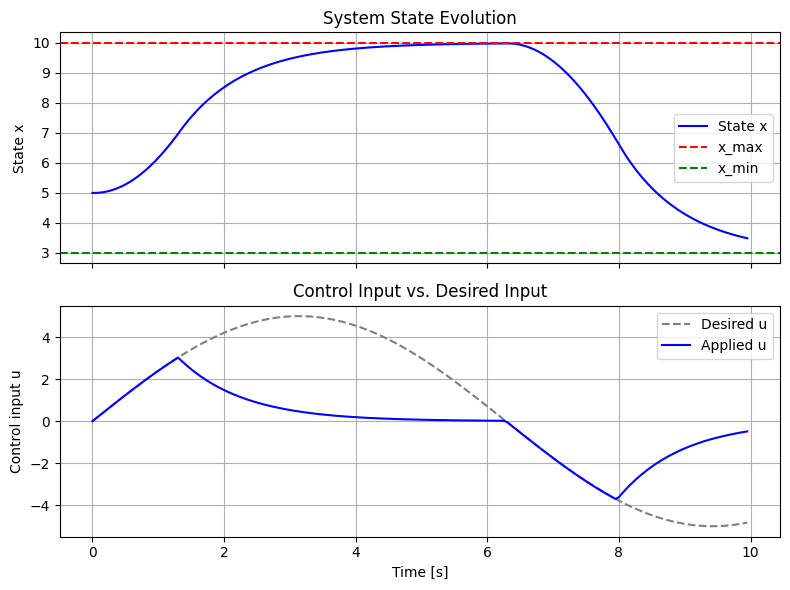

In [3]:

# Example usage
x0 = 5.0  # Initial state
T = 10.0  # Simulation time
dt = 0.05  # Time step

# Example usage
x_max = 10.0
x_min = 3.0
gamma = 1.0
controller = CBFController(x_min, x_max, gamma)

x = 5.0  # Current state
u_des = 2.0  # Desired control input
u_safe = controller.compute_control(x, u_des)
# Define a sine wave as desired input
u_des_func = lambda t: 5.0 * np.sin(0.5 * t)

# Run simulation and plot results
simulate_and_plot(controller, x0, u_des_func, T, dt)


In [4]:
class SimpleCBFController:
    def __init__(self, x_min, x_max, gamma):
        self.x_min = x_min
        self.x_max = x_max
        self.gamma = gamma  # CBF parameter

    def compute_control(self, x, u_des):
        """Enforce CBF constraint using simple clipping."""
        u_min = -self.gamma * (x - self.x_min)
        u_max = self.gamma * (self.x_max - x)
        return np.clip(u_des, u_min, u_max)

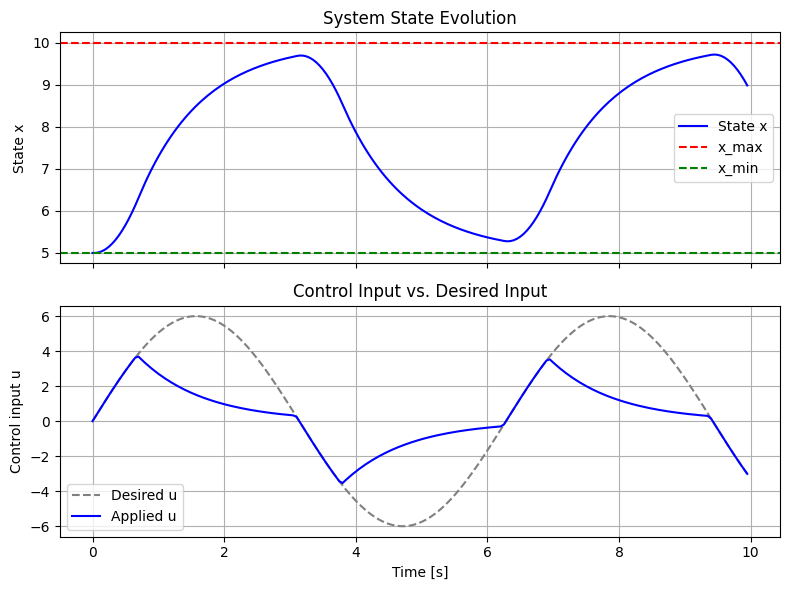

In [5]:
# Define problem parameters
x_min = 5.0
x_max = 10.0
gamma = 1.0
x0 = 5.0  # Initial state
T = 10.0  # Simulation time
dt = 0.05  # Time step

# Create the simple CBF controller
simple_controller = SimpleCBFController(x_min, x_max, gamma)

# Define a sine wave as the desired control input
u_des_func = lambda t: 6.0 * np.sin(1.0 * t)

# Simulate and plot the results
simulate_and_plot(simple_controller, x0, u_des_func, T, dt)
